# Compute the Optical Flow to determine the direction of the vehicles

Before running the code make sure to have all the videos uploaded in the google collab environment by uploading the videos.zip file from the github repository.


In [ ]:
!unzip videos.zip 

Archive:  videos.zip
 extracting: PXL_20210822_180954405.mp4  
  inflating: traffic_camera.mp4      


### Auxiliary functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import filters
from scipy.stats import mode
import cv2

# Function to display images
def display_image(img, title='', size=None):
    plt.gray()
    h = plt.imshow(img, interpolation='none')
    if size:
        dpi = h.figure.get_dpi()/size
        h.figure.set_figwidth(img.shape[1] / dpi)
        h.figure.set_figheight(img.shape[0] / dpi)
        h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)
        h.axes.set_position([0, 0, 1, 1])
        h.axes.set_xlim(-1, img.shape[1])
        h.axes.set_ylim(img.shape[0], -1)
    plt.grid(False)
    plt.title(title)  
    plt.show()

# Function to preprocess images before using them
def preprocessing(frame):
    # Resize of frame while keeping ratio
    if frame.shape[1] > 800:
      scale_percent = 20 
      width = int(frame.shape[1] * scale_percent / 100)
      height = int(frame.shape[0] * scale_percent / 100)
      dim = (width, height)
    else: # if the width is already small don't make it smaller
      dim = (frame.shape[1], frame.shape[0])
    ## Function to resize image
    resized_frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    
    # Convert to graylevel
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    
    return gray_frame

## Static video


### Obtain background

In [ ]:
def obtain_background(file_name):
  cap = cv2.VideoCapture(file_name)
  # read the video frame
  ret,frame = cap.read() 

  frame_gray = preprocessing(frame)

  # Define a 3D matrix to store the 100 images to generate the average
  width = frame_gray.shape[1]
  height = frame_gray.shape[0]
  all_frames = np.zeros((100,height,width))

  # Loop over frames from the video stream and accumulate all frames in a single variable                                                                                                    
  for i in range(100):
      if i%10 == 0:
        print ('Processing frame {}'.format (i))
      
      # Store the frame in the matrix
      all_frames[i,:,:] = frame_gray

      ret,frame = cap.read()
      if ret is False: # If something failed ...
          break
      frame_gray = preprocessing(frame)

  # Average the 100 frames
  background = np.average(all_frames,axis=0)

  # Convert to uint8 data type
  background = background.astype(np.uint8)

  return background

In [ ]:
background = obtain_background('PXL_20210822_180954405.mp4')

Processing frame 0
Processing frame 10
Processing frame 20
Processing frame 30
Processing frame 40
Processing frame 50
Processing frame 60
Processing frame 70
Processing frame 80
Processing frame 90


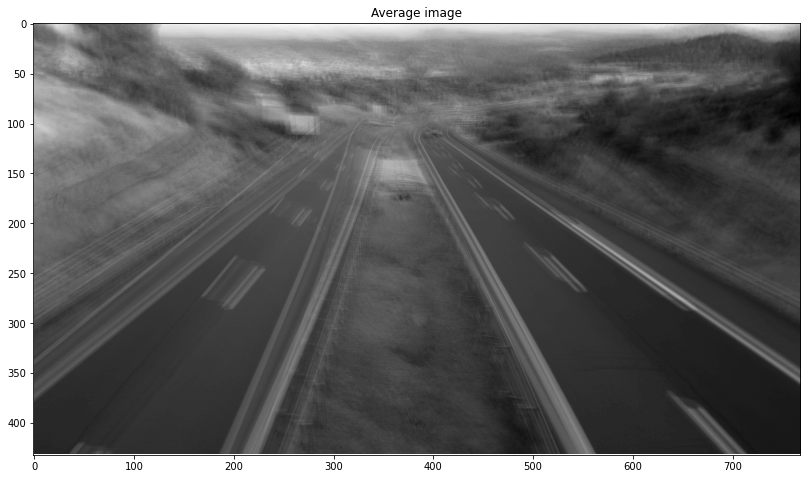

In [ ]:
display_image(background, 'Average image', size=1)

The video has some movement, it will need to be stabilized to be able to obtain a clear background.

### Video stabilization

// TODO

### Already stabilized video 
#### Obtain background


Processing frame 0
Processing frame 10
Processing frame 20
Processing frame 30
Processing frame 40
Processing frame 50
Processing frame 60
Processing frame 70
Processing frame 80
Processing frame 90


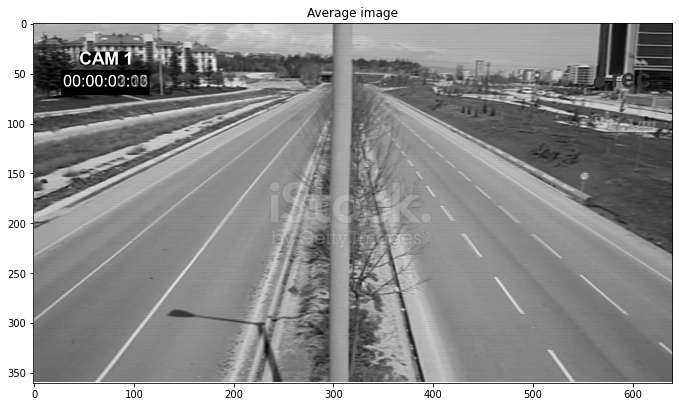

In [ ]:
traffic_cam_background = obtain_background('traffic_camera.mp4')
display_image(traffic_cam_background, 'Average image', size=1)

## Detecting moving objects

## Inside car video